In [88]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
# text in Western (Windows 1252)

import pickle
import numpy as np
# import StringIO
import math
from keras import optimizers, metrics
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.constraints import maxnorm
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.models import load_model
# from keras import backend as Input
np.random.seed(7)

In [2]:
# %run ../../../prepare_data.py

import sys
sys.path.insert(0, '../../../')
from prepare_data import *

In [4]:
# X_train, X_other_features_train, y_train, X_validate, X_other_features_validate, y_validate = generate_full_matrix_inputs()
# save_inputs('../../internal_representations/inputs/shuffeled_matrix_train_inputs_other_features_multilabel.h5', X_train, y_train, other_features = X_other_features_train)
# save_inputs('../../internal_representations/inputs/shuffeled_matrix_validate_inputs_other_features_multilabel.h5', X_validate, y_validate,  other_features = X_other_features_validate)
X_train, X_other_features_train, y_train = load_inputs('../../internal_representations/inputs/shuffeled_matrix_train_inputs_other_features_multilabel.h5', other_features=True)
X_validate, X_other_features_validate, y_validate = load_inputs('../../internal_representations/inputs/shuffeled_matrix_validate_inputs_other_features_multilabel.h5', other_features=True)

In [24]:
# X_other_features = create_X_features(content)
# print (X_other_features[178200])
decode_position = 30
print (decode_input(X_train[decode_position], dictionary))
# print (X_other_features_train[0])
print (decode_X_features(feature_dictionary, [X_other_features_train[decode_position]]))
# print (len(X_other_features_train[0]))

navleèeta
Vmip3d--n
None


In [191]:
num_examples = len(X_train) # training set size
# nn_input_dim = max_word * len(dictionary) # input layer dimensionality
# nn_output_dim = max_num_vowels * max_num_vowels # output layer dimensionality
nn_output_dim = 11
nn_hdim = 516
batch_size = 16
actual_epoch = 1
num_fake_epoch = 20

# Gradient descent parameters (I picked these by hand)
# epsilon = 1 # learning rate for gradient descent
# reg_lambda = 1 # regularization strength

In [192]:
# word_processor = Sequential()
# word_processor.add(Conv1D(43, (3), input_shape=(23, 43), padding='same', activation='relu'))
# word_processor.add(Conv1D(43, (2), padding='same', activation='relu'))
# word_processor.add(Conv1D(43, (2), padding='same', activation='relu'))
# word_processor.add(MaxPooling1D(pool_size=2))
# word_processor.add(Flatten())
# word_processor.add(Dense(516, activation='relu', kernel_constraint=maxnorm(3)))

# metadata_processor = Sequential()
# metadata_processor.add(Dense(256, input_dim=167, activation='relu'))

# model = Sequential()
# model.add(Merge([word_processor, metadata_processor], mode='concat'))  # Merge is your sensor fusion buddy
# model.add(Dense(1024, input_dim=(516 + 256), activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(nn_output_dim, activation='sigmoid'))


# -------------------------------------------------------

conv_input_shape=(23, 43)
othr_input = (167, )

conv_input = Input(shape=conv_input_shape, name='conv_input')
x_conv = Conv1D(43, (3), padding='same', activation='relu')(conv_input)
x_conv = Conv1D(43, (3), padding='same', activation='relu')(x_conv)
x_conv = MaxPooling1D(pool_size=2)(x_conv)
x_conv = Flatten()(x_conv)
# x_conv = Dense(516, activation='relu', kernel_constraint=maxnorm(3))(x_conv)

othr_input = Input(shape=othr_input, name='othr_input')
# x_othr = Dense(256, input_dim=167, activation='relu')(othr_input)
# x_othr = Dropout(0.3)(x_othr)
# x_othr = Dense(256, activation='relu')(othr_input)

x = concatenate([x_conv, othr_input])
# x = Dense(1024, input_dim=(516 + 256), activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(nn_output_dim, activation='sigmoid')(x)

# model = Model(inputs=[conv_input, othr_input], output=x)

In [193]:
model = Model(inputs=[conv_input, othr_input], outputs=x)

# epochs = 5
# lrate = 0.1
# decay = lrate/epochs
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Compile model
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt = optimizers.Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[actual_accuracy,])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [194]:
history = model.fit_generator(generate_fake_epoch(X_train, X_other_features_train, y_train, batch_size), X_train.shape[0]/(batch_size * num_fake_epoch), epochs=actual_epoch*num_fake_epoch, validation_data=([X_validate, X_other_features_validate], y_validate))

# model.fit([X_train, X_other_features_train], y_train, validation_data=([X_validate, X_other_features_validate], y_validate), epochs=1, batch_size=16)

Epoch 1/20
1336/1335 [==============================] - 35s - loss: 0.2042 - actual_accuracy: 0.2449 - val_loss: 0.1600 - val_actual_accuracy: 0.4845
Epoch 2/20
1336/1335 [==============================] - 41s - loss: 0.1536 - actual_accuracy: 0.4509 - val_loss: 0.1461 - val_actual_accuracy: 0.4918
Epoch 3/20
1336/1335 [==============================] - 43s - loss: 0.1374 - actual_accuracy: 0.5199 - val_loss: 0.1338 - val_actual_accuracy: 0.5627
Epoch 4/20
1336/1335 [==============================] - 46s - loss: 0.1287 - actual_accuracy: 0.5671 - val_loss: 0.1259 - val_actual_accuracy: 0.5851
Epoch 5/20
1336/1335 [==============================] - 48s - loss: 0.1206 - actual_accuracy: 0.6069 - val_loss: 0.1193 - val_actual_accuracy: 0.6053
Epoch 6/20
1336/1335 [==============================] - 46s - loss: 0.1144 - actual_accuracy: 0.6372 - val_loss: 0.1134 - val_actual_accuracy: 0.6517
Epoch 7/20
1336/1335 [==============================] - 48s - loss: 0.1083 - actual_accuracy: 0.6658

In [195]:
name = '1_epoch'
model.save(name + '.h5')
output = open(name + '_history.pkl', 'wb')
pickle.dump(history.history, output)
output.close()

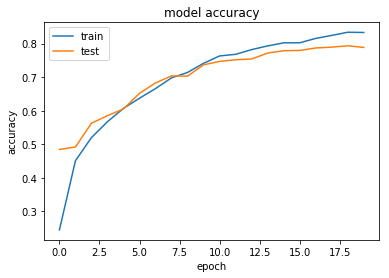

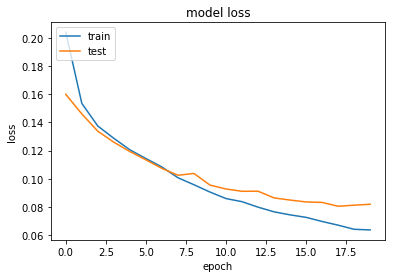

In [196]:
import matplotlib.pyplot as plt
plt.plot(history.history['actual_accuracy'])
plt.plot(history.history['val_actual_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
model = load_model('test.h5')

In [6]:
h5f.close()

NameError: name 'h5f' is not defined

In [67]:
# evaluate the model
scores = model.evaluate([X_validate, X_other_features_validate], y_validate)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

108736/108961 [============================>.] - ETA: 0s
acc: 96.57%


In [187]:
pos = 0
print(decode_input(X_validate[pos], dictionary))
# predictions = model.predict([X_validate, X_other_features_validate])
predictions2 = model.predict([X_validate[pos:pos+1], X_other_features_validate[pos:pos+1]])
# print(predictions2)
print(np.round(predictions2)[0])
# predictions = np.round(predictions)
print(y_validate[pos])
# accuracy = sum([1 if np.all(y_validate[i] == predictions[i]) else 0 for i in range(X_validate.shape[0])])/float(X_validate.shape[0])
# print(accuracy)


import keras.backend as K

def act_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.mean(K.equal(K.round(y_true), K.round(y_pred)), axis=-1), 1.0))


def mean_pred2(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))
#     return K.mean(K.all(K.equal(y_true, y_pred), axis=-1))
#     return K.equal(K.round(y_true), K.round(y_pred))

print(mean_pred(y_validate[pos], predictions[pos]).eval())
print(mean_pred(np.array([[ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
                          [ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]), 
                np.array([[ 0.,  0.51,  0.,  0.51,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
                          [ 0.,  0.92,  0.,  0.51,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])).eval())
# print(mean_pred(y_validate[pos], predictions[pos]))
# print(mean_pred2(y_validate[pos], predictions[pos]))
print(metrics.categorical_accuracy(y_validate[pos], predictions[pos]))

nerazloènejši
[ 0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
1.0
1.0
Elemwise{Cast{float32}}.0


In [ ]:
predictions = model.predict(X[429145:])

In [21]:
decode_position(predictions[0], max_num_vowels)

[1, 0]

In [23]:
def test_accuracy(predictions, y):
    dictionary, max_word, max_num_vowels, content, vowels, accetuated_vowels = create_dict()
    num_of_pred = len(predictions)
    num_of_correct_pred = 0
    for i in range(predictions.shape[0]):
        if decode_position(predictions[i], max_num_vowels) == decode_position(y[i], max_num_vowels):
            num_of_correct_pred += 1

    return (num_of_correct_pred/float(num_of_pred)) * 100


print(test_accuracy(predictions, y[429145:]))

READING CONTENT...
CONTENT READ SUCCESSFULY
CREATING DICTIONARY...
DICTIONARY CREATION SUCCESSFUL!
107287
96.5186835311


In [17]:
predictions.shape

(107287, 121)

In [12]:
print max_num_vowels

11


In [31]:
dictionary, max_word, max_num_vowels, content, vowels, accetuated_vowels = create_dict()
feature_dictionary = create_feature_dictionary(content)
def generate_input_from_word(word, max_word, dictionary):
    x = np.zeros((max_word, len(dictionary)))
    j = 0
    for c in list(word):
        index = 0
        for d in dictionary:
            if c == d:
                x[j, index] = 1
                break
            index += 1
        j += 1
    return x

# model = load_model()
# prediction = predict(model, generate_input_from_word('hidrija'))
# print decode_position(prediction[0])

READING CONTENT...
CONTENT READ SUCCESSFULY
CREATING DICTIONARY...
DICTIONARY CREATION SUCCESSFUL!


In [190]:
%run ../../../prepare_data.py
# generate_X_and_y(dictionary, max_word, max_num_vowels, content, vowels, accetuated_vowels, feature_dictionary)